In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sn

import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
X_tr = training_data.data.detach().cpu().numpy().reshape(-1, 28 * 28).astype(np.float32) / 255.
y_tr = training_data.targets.detach().cpu().numpy().astype(np.int32)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
X_te = test_data.data.detach().cpu().numpy().reshape(-1, 28 * 28).astype(np.float32) / 255.
y_te = test_data.targets.detach().cpu().numpy().astype(np.int32)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print(f'train dataset with input shape = {X_tr.shape}, label shape={y_tr.shape}')
print(f'test dataset with input shape = {X_te.shape}, label shape={y_te.shape}')

train dataset with input shape = (60000, 784), label shape=(60000,)
test dataset with input shape = (10000, 784), label shape=(10000,)


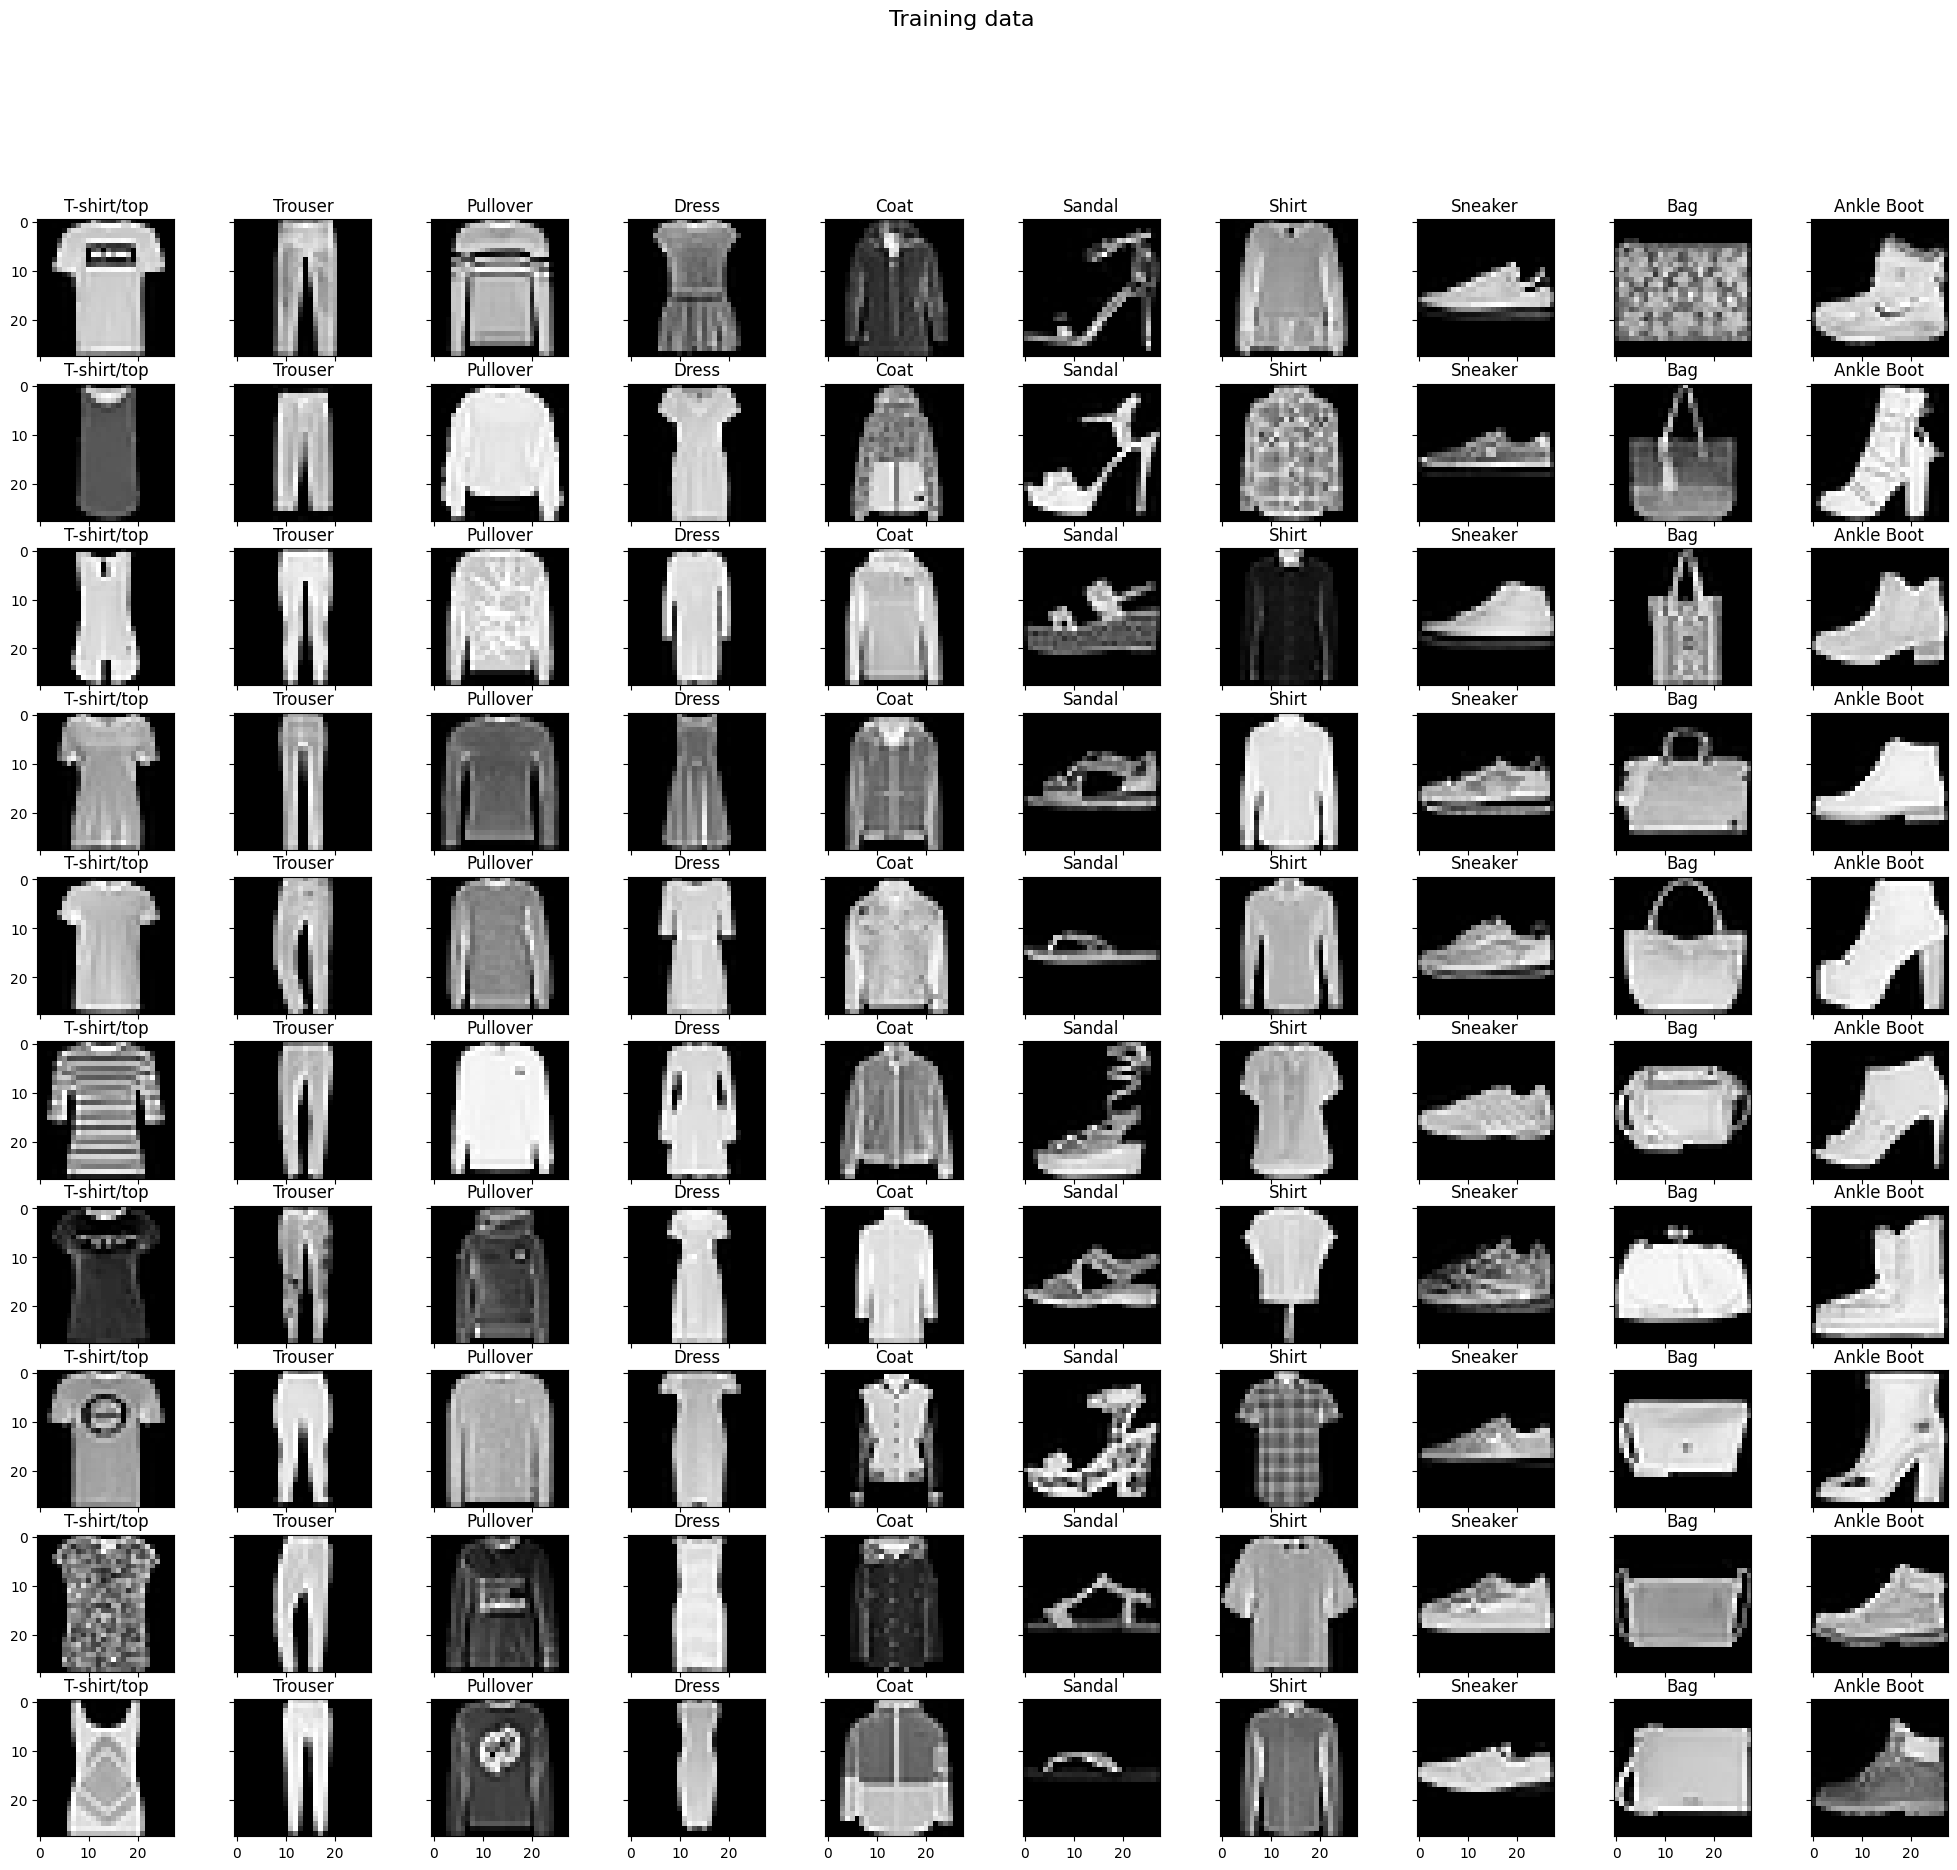

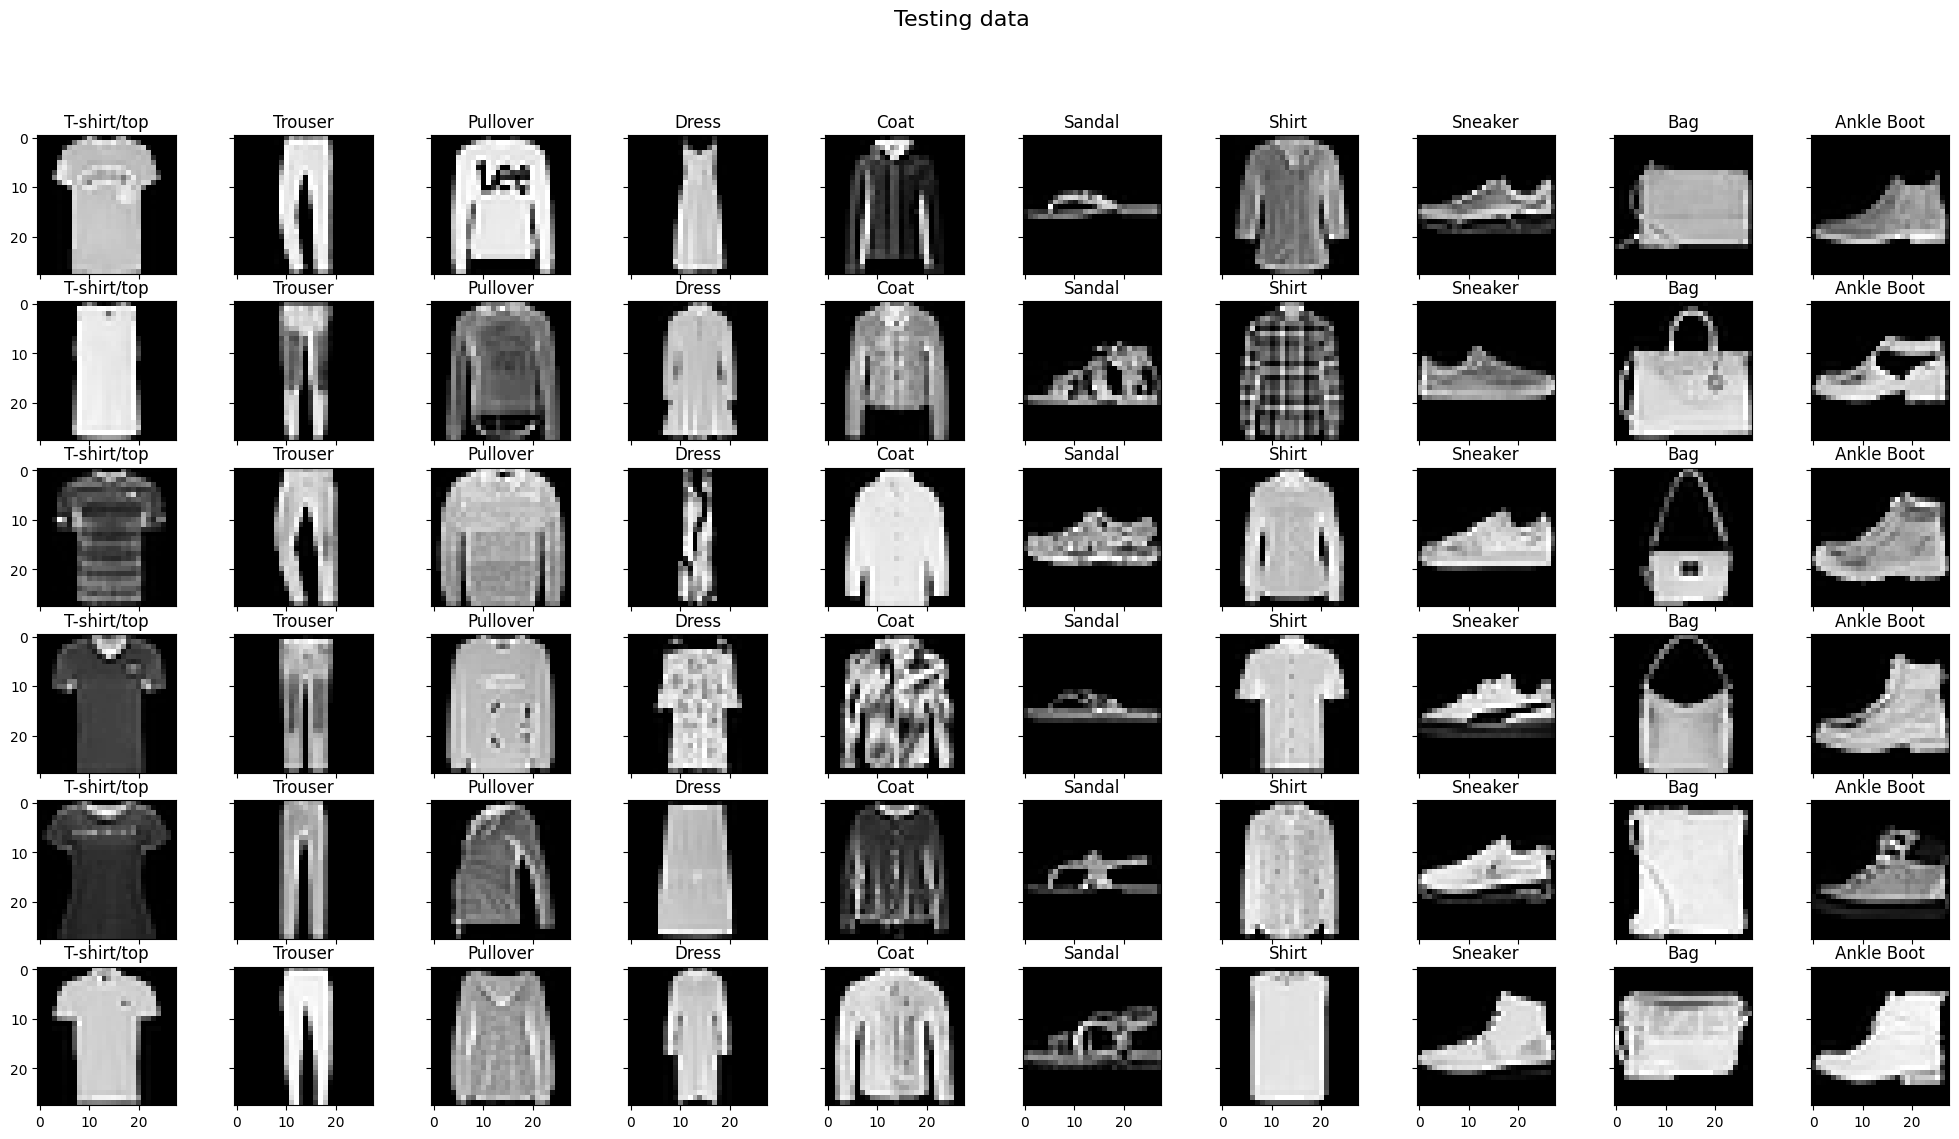

In [16]:
Xs = [X_tr[y_tr==i] for i in range(10)]
m = 10

fig, axes = plt.subplots(nrows=m, ncols=len(classes), sharex=True, sharey=True, figsize=(2.5*len(classes), 2.1*m))
fig.suptitle('Training data', fontsize=16)
for r, row in enumerate(axes):
    for i, ax in enumerate(row):
        ax.set_title(classes[i])
        ax.imshow(Xs[i][r].reshape(28, 28), cmap='gray')
plt.show()


Xs = [X_te[y_te==i] for i in range(10)]
m = 6

fig, axes = plt.subplots(nrows=m, ncols=len(classes), sharex=True, sharey=True, figsize=(2.5*len(classes), 2.1*m))
fig.suptitle('Testing data', fontsize=16)
for r, row in enumerate(axes):
    for i, ax in enumerate(row):
        ax.set_title(classes[i])
        ax.imshow(Xs[i][r].reshape(28, 28), cmap='gray')
plt.show()

In [2]:
# define NN's struct
class Encoder(torch.nn.Module):
    def __init__(self, coded_channels, mid_channels=32):
        super(Encoder, self).__init__()

        kernel_size = 3
        pool_size = 2
        self.conv1 = torch.nn.Conv2d(1, mid_channels, kernel_size, padding=1)
        self.conv2 = torch.nn.Conv2d(mid_channels, coded_channels, kernel_size, padding=1)
        self.bn = torch.nn.BatchNorm2d(coded_channels)
        self.pool = torch.nn.MaxPool2d(pool_size, pool_size)
    
    def forward(self, x):
        # first layer
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool(x)
        # 14 x 14 x mid_channels

        # second layer
        x = self.conv2(x)
        x = self.bn(x) # Batch Normlize
        x = torch.nn.functional.relu(x)
        x = self.pool(x)
        # 7 x 7 x coded_channels

        return x

class Decoder(torch.nn.Module):
    def __init__(self, coded_channels, mid_channels = 32):
        super(Decoder, self).__init__()

        kernel_size = 2
        self.t_conv1 = torch.nn.ConvTranspose2d(coded_channels, mid_channels, kernel_size, stride=2)
        self.t_conv2 = torch.nn.ConvTranspose2d(mid_channels, 1, kernel_size, stride=2)

    def forward(self, x):
        #first layer
        x = self.t_conv1(x)
        x = torch.nn.functional.relu(x)
        # 14 x 14 x mid_channels

        #second layer
        x = self.t_conv2(x)
        x = torch.sigmoid(x) # ensure ouput is in [0, 1]
        # 28 x 28 x 1

        return x

class Classifier(torch.nn.Module):
    def __init__(self, coded_channels, dorpout_p):
        super(Classifier, self).__init__()

        self.seq = torch.nn.Sequential(
            torch.nn.Linear(7*7*coded_channels, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(dorpout_p),

            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(dorpout_p),
            
            torch.nn.Linear(64, len(classes)), # since we are using Cross Entropy, no need for softmax
        )

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.seq(x)
        return logits

class CNN_with_AutoEncoder:
    def __init__(self, training_data, batch=16384, coded_channels=8, learning_rate=1e-3, dorpout_p=0.5, autoencoder_epoch=128, classifier_epoch=256) -> None:
        self.batch = batch
        self.coded_channels = coded_channels
        self.learning_rate = learning_rate
        self.dorpout_p = dorpout_p
        self.autoencoder_epoch = autoencoder_epoch
        self.classifier_epoch = classifier_epoch

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.encoder = Encoder(self.coded_channels)
        self.decoder = Decoder(self.coded_channels)
        self.classifier = Classifier(self.coded_channels, self.dorpout_p)

        self.encoder.to(self.device)
        self.decoder.to(self.device)
        self.classifier.to(self.device)

        self.train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=self.batch)

    # the X, y is useless, just for fit the API
    def fit(self, X, y):
        # set the net work to training mode
        self.encoder.train()
        self.decoder.train()
        self.classifier.train()


        ae_params = [
            {'params': self.encoder.parameters()},
            {'params': self.decoder.parameters()}
        ]
        ae_loss = torch.nn.MSELoss()
        ae_optim = torch.optim.Adam(ae_params, lr=self.learning_rate)

        for _ in range(self.autoencoder_epoch):
            for X, _ in self.train_dataloader:
                X = X.to(self.device)

                coded = self.encoder(X)
                outputs = self.decoder(coded)

                loss = ae_loss(X, outputs)

                ae_optim.zero_grad()
                loss.backward()
                ae_optim.step()


        clf_params = [
            {'params': self.encoder.parameters()},
            {'params': self.classifier.parameters()}
        ]
        clf_loss = torch.nn.CrossEntropyLoss()
        clf_optim = torch.optim.Adam(clf_params, lr= self.learning_rate)

        for _ in range(self.classifier_epoch):
            for X, y in self.train_dataloader:
                X = X.to(self.device)
                y = y.to(self.device)

                coded = self.encoder(X)
                pred = self.classifier(coded)
                loss = clf_loss(pred, y) # since we are using Cross Entropy, no need for softmax

                clf_optim.zero_grad()
                loss.backward()
                clf_optim.step()
    
    def predict(self, X):
        # set the net work to eval mode
        self.encoder.eval()
        self.decoder.eval()
        self.classifier.eval()

        n = len(X)
        res = np.empty(n)
        
        m = (n + self.batch - 1) // self.batch
        with torch.no_grad():
            for i in range(m):
                i = i * self.batch
                f = min(i + self.batch, n)
                input = torch.unflatten(torch.from_numpy(X[i:f]), dim=-1, sizes=(1, 28, 28)).to(self.device)
                res[i:f] = self.classifier(self.encoder(input)).detach().cpu().argmax(1).numpy()
        return res

In [3]:
def hyper_para_plot(params, gen, name=''):
    tr_err = []
    te_err = []

    for param in params:
        model = gen(param)
        model.fit(X_tr, y_tr)

        tr_err.append(1-accuracy_score(y_tr, model.predict(X_tr)))
        te_err.append(1-accuracy_score(y_te, model.predict(X_te)))
    
    plt.plot(params, tr_err, label='train')
    plt.plot(params, te_err, label='test')
    plt.ylim([0, 1])
    plt.xlabel(name)
    plt.ylabel('error rate')
    plt.gca().legend()
    plt.show()

In [ ]:
hyper_para_plot([3, 5, 10, 15, 20, 25], lambda p: KNeighborsClassifier(n_neighbors=p), 'k')

In [ ]:
hyper_para_plot([512, 256, 128], lambda p: MLPClassifier(hidden_layer_sizes=(p, 128, 64), random_state=seed), 'first layer nodes')

In [ ]:
hyper_para_plot([512, 256, 128, 64], lambda p: MLPClassifier(hidden_layer_sizes=(256, p, 64), random_state=seed), 'second layer nodes')

In [ ]:
hyper_para_plot([128, 64, 32, 16], lambda p: MLPClassifier(hidden_layer_sizes=(256, 128, p), random_state=seed), 'thrid layer nodes')

In [4]:
models = {}

models['MLPClassifier'] = MLPClassifier(hidden_layer_sizes=(256, 128, 64), random_state=seed)
models['KNeighborsClassifier'] = KNeighborsClassifier(n_neighbors=15)
models['LogisticRegression'] = LogisticRegression(max_iter=500, random_state=seed)
models['RandomForestClassifier'] = RandomForestClassifier(n_estimators=20, random_state=seed)
models['CNN_with_AutoEncoder'] = CNN_with_AutoEncoder(training_data)

In [5]:
for k, model in models.items():
    model.fit(X_tr, y_tr)

C:\Users\MikeX\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
res_tab = PrettyTable()
res_tab.field_names = ['model', 'training accuracy', 'testing accuracy', 'avg. predict time']

for name, model in models.items():
    tic = time.perf_counter()
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    toc = time.perf_counter()
    
    avg_time = (toc - tic) / (len(pred_tr) + len(pred_te))

    res_tab.add_row([
        name,
        f'{accuracy_score(y_tr, pred_tr)*100:5.2f}%',
        f'{accuracy_score(y_te, pred_te)*100:5.2f}%',
        f'{avg_time*1e9:6.1f}ns'
    ])

print(res_tab)

+------------------------+-------------------+------------------+-------------------+
|         model          | training accuracy | testing accuracy | avg. predict time |
+------------------------+-------------------+------------------+-------------------+
|     MLPClassifier      |       99.27%      |      89.07%      |      4322.8ns     |
|  KNeighborsClassifier  |       86.76%      |      84.62%      |    1643139.5ns    |
|   LogisticRegression   |       87.98%      |      84.30%      |      3159.5ns     |
| RandomForestClassifier |       99.90%      |      86.60%      |      6951.6ns     |
|  CNN_with_AutoEncoder  |       97.19%      |      91.60%      |      7177.0ns     |
+------------------------+-------------------+------------------+-------------------+


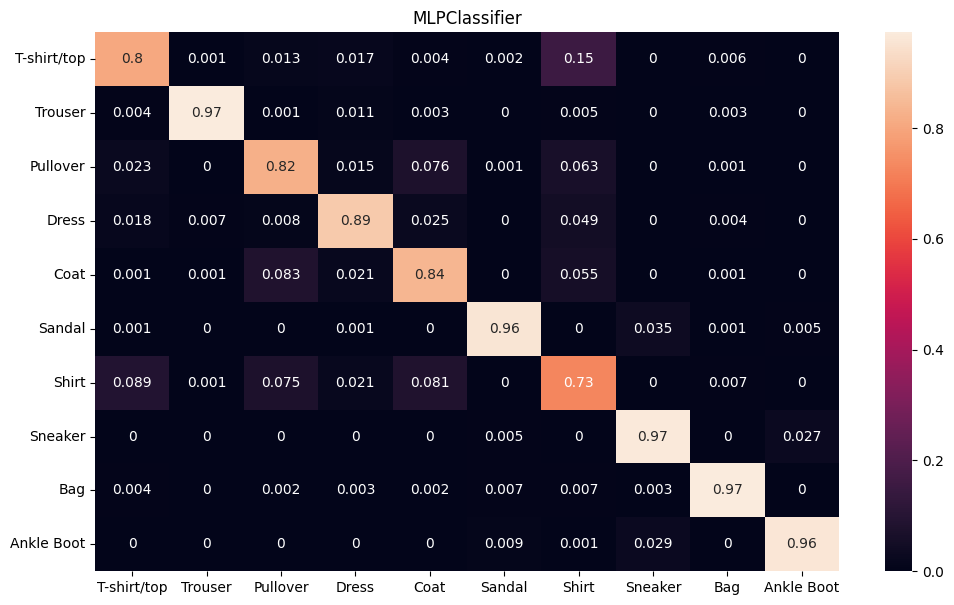

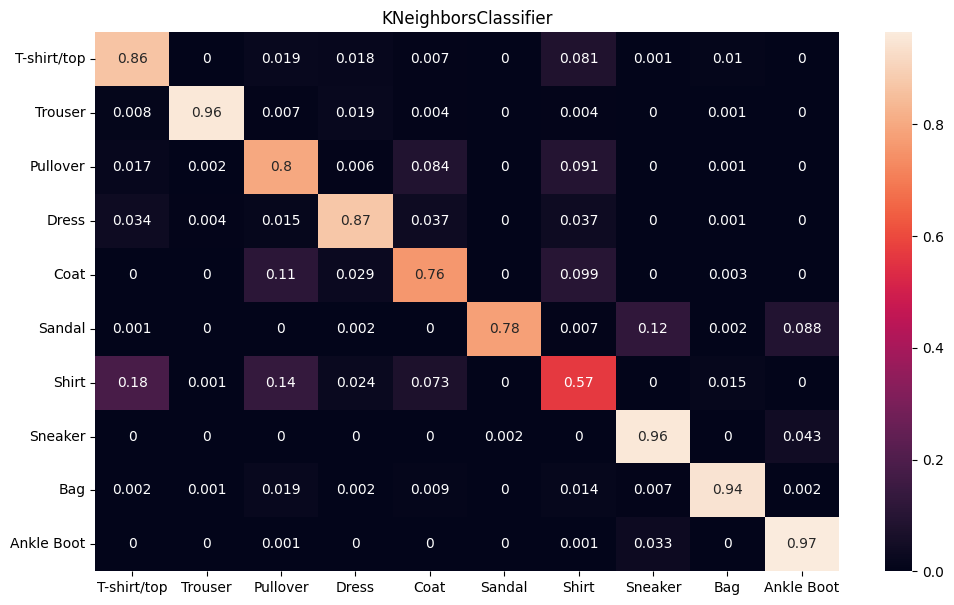

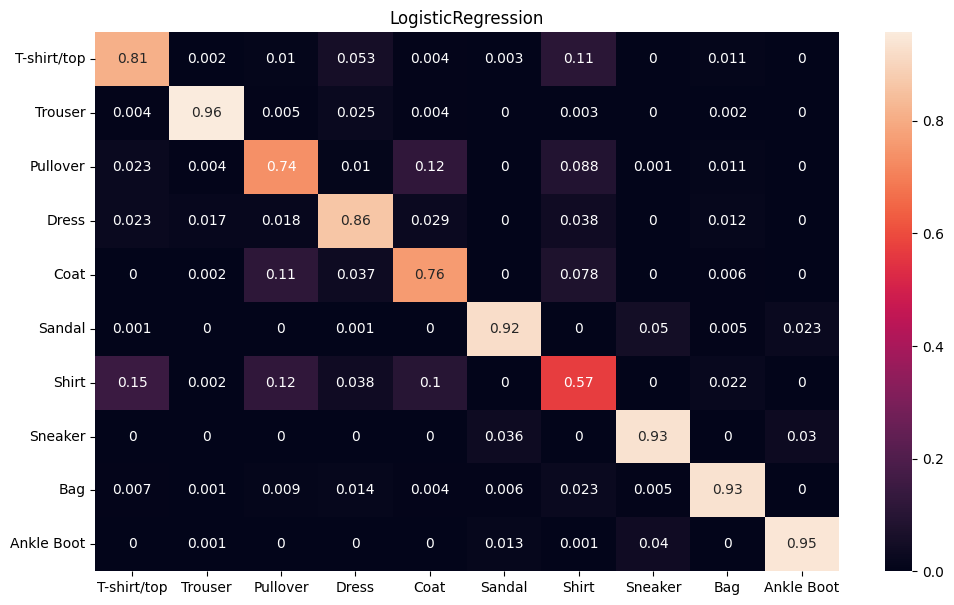

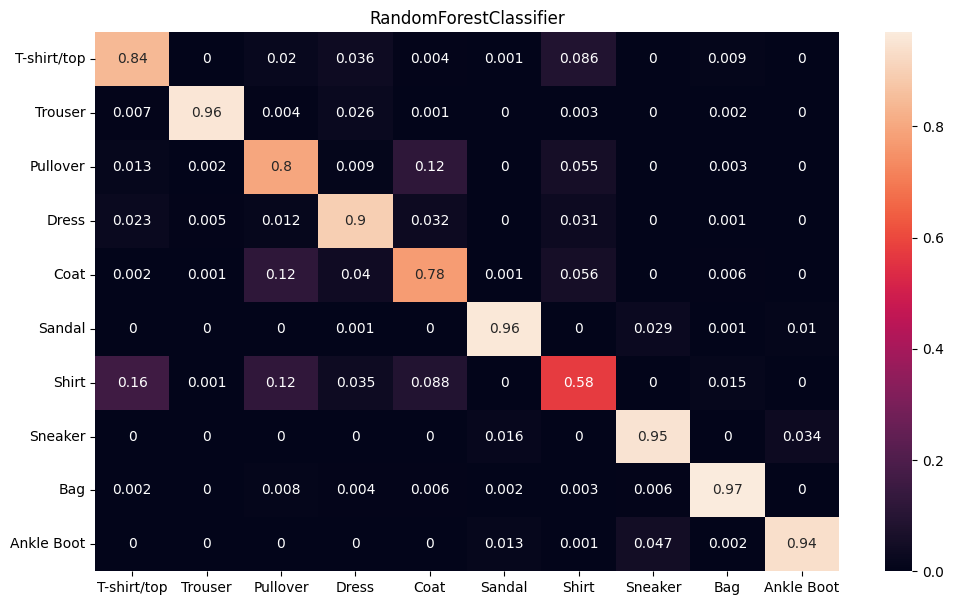

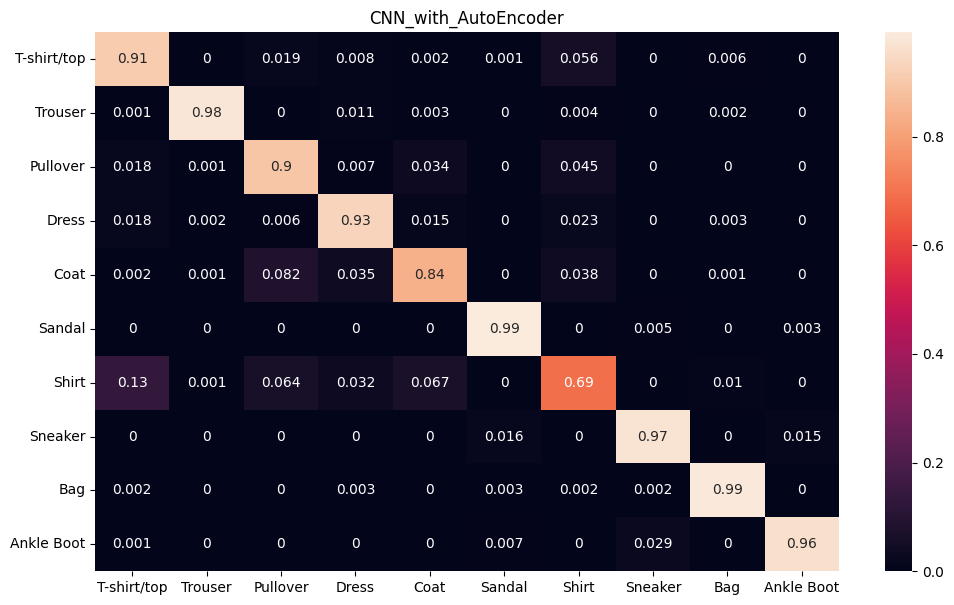

In [7]:
for name, model in models.items():
    cf_matrix = confusion_matrix(y_te, model.predict(X_te))
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = list(classes), columns = list(classes))
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.title(name)
    plt.show()

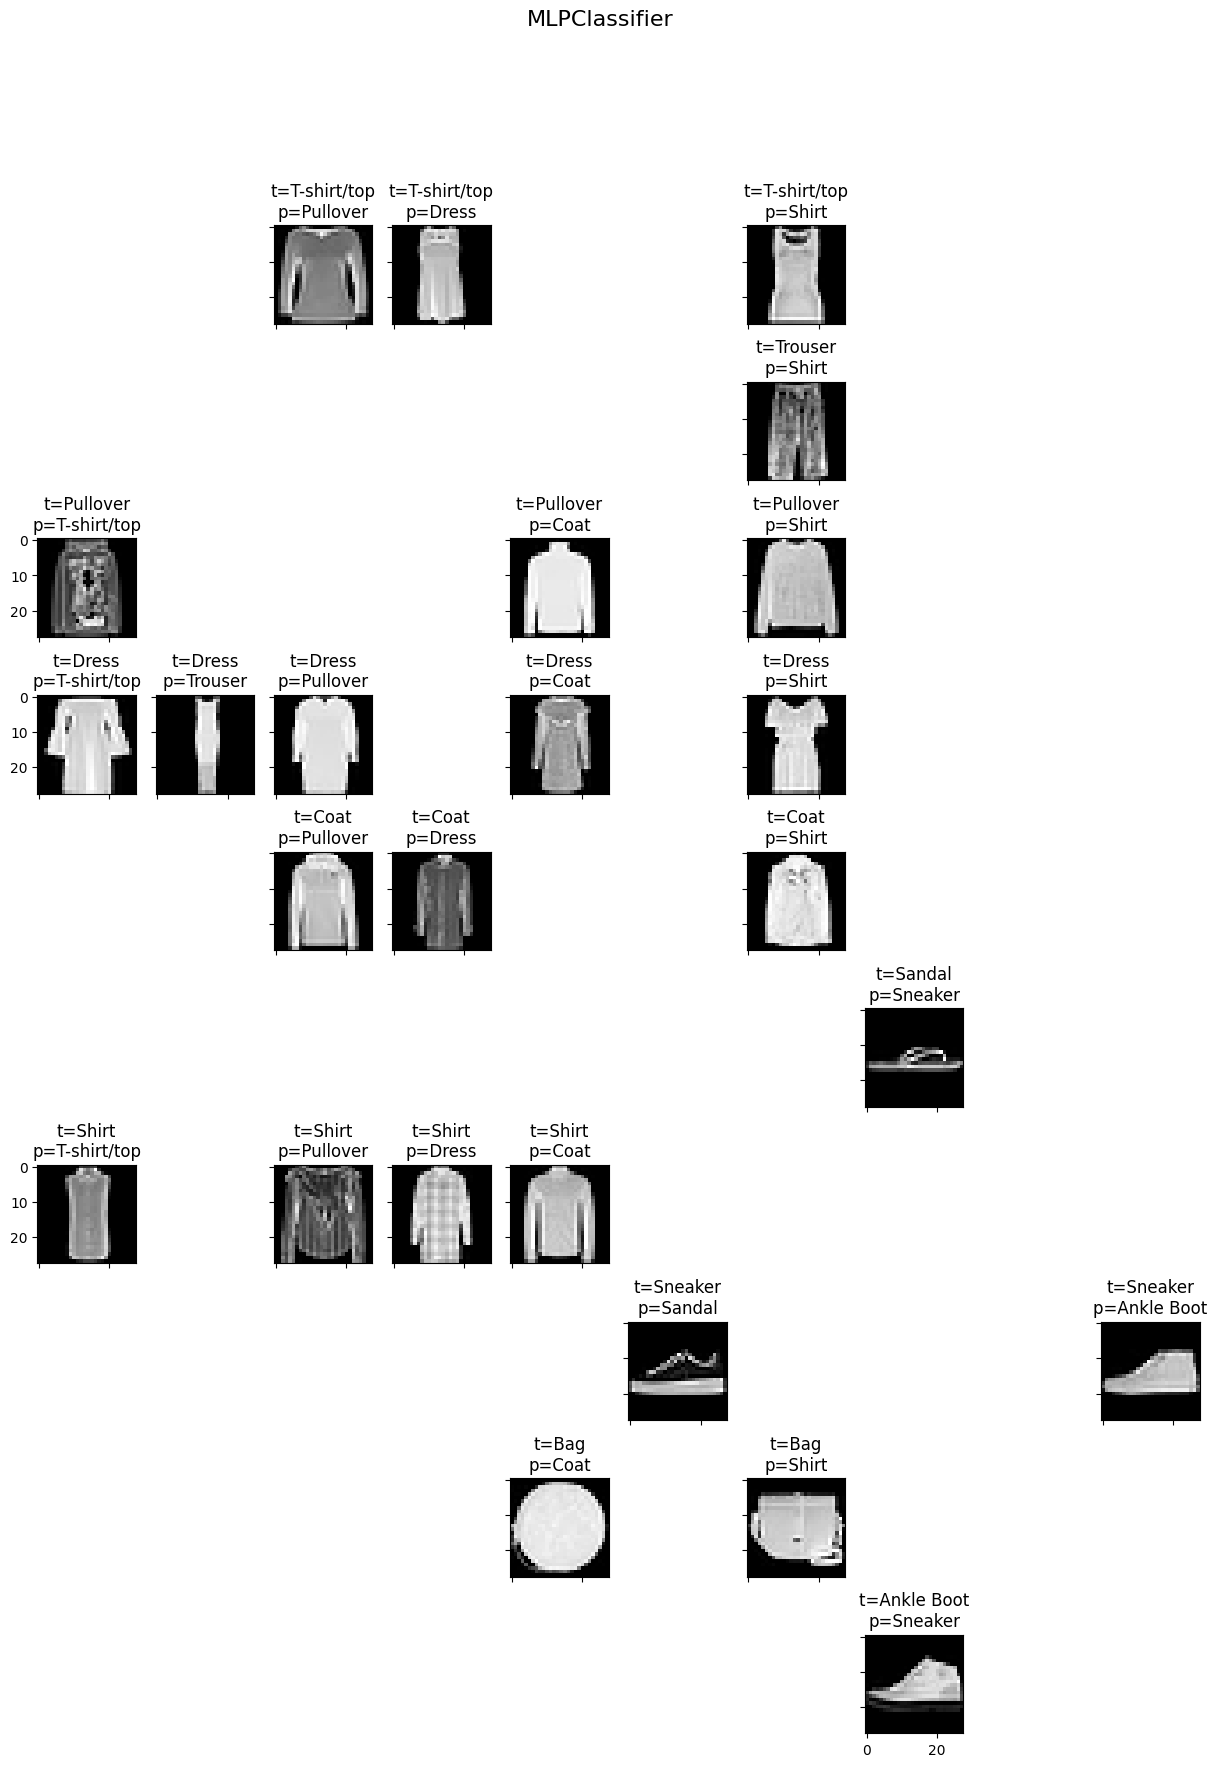

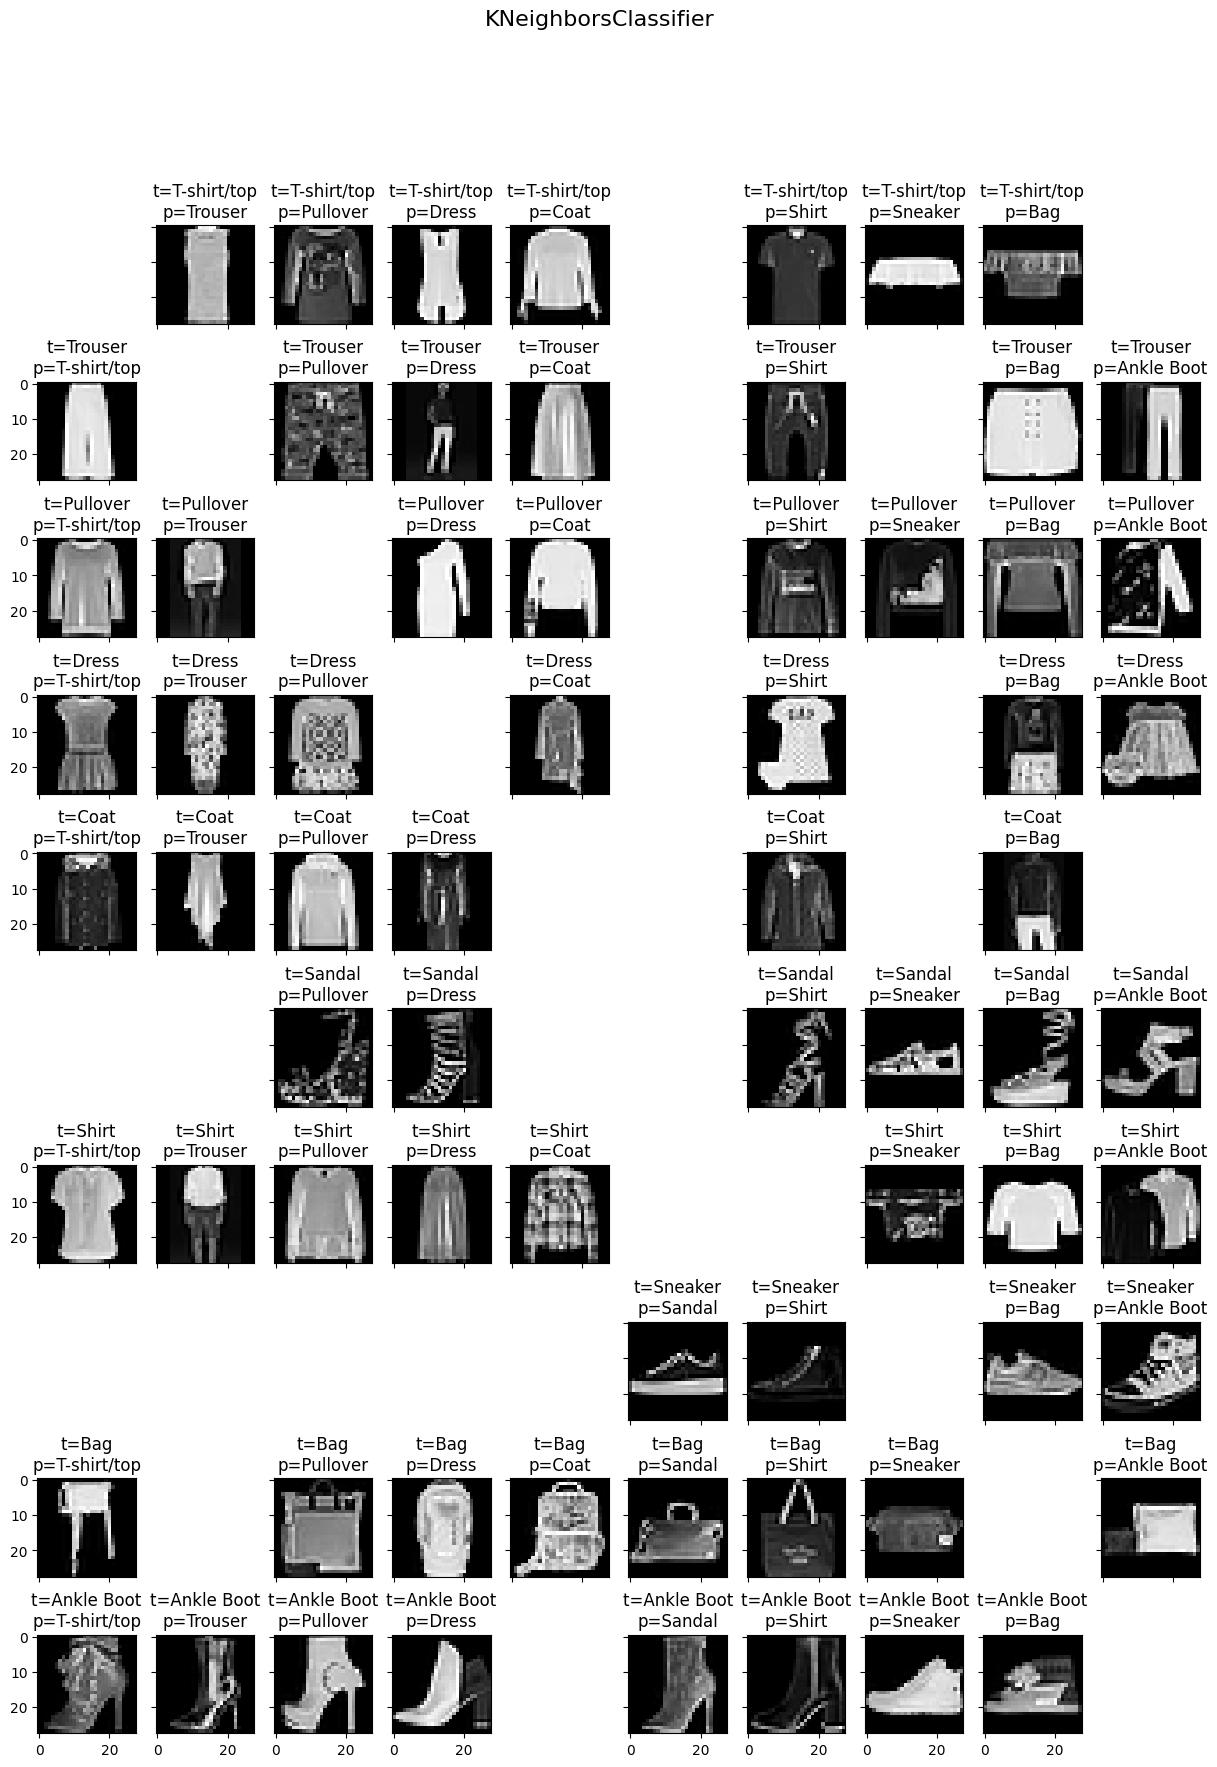

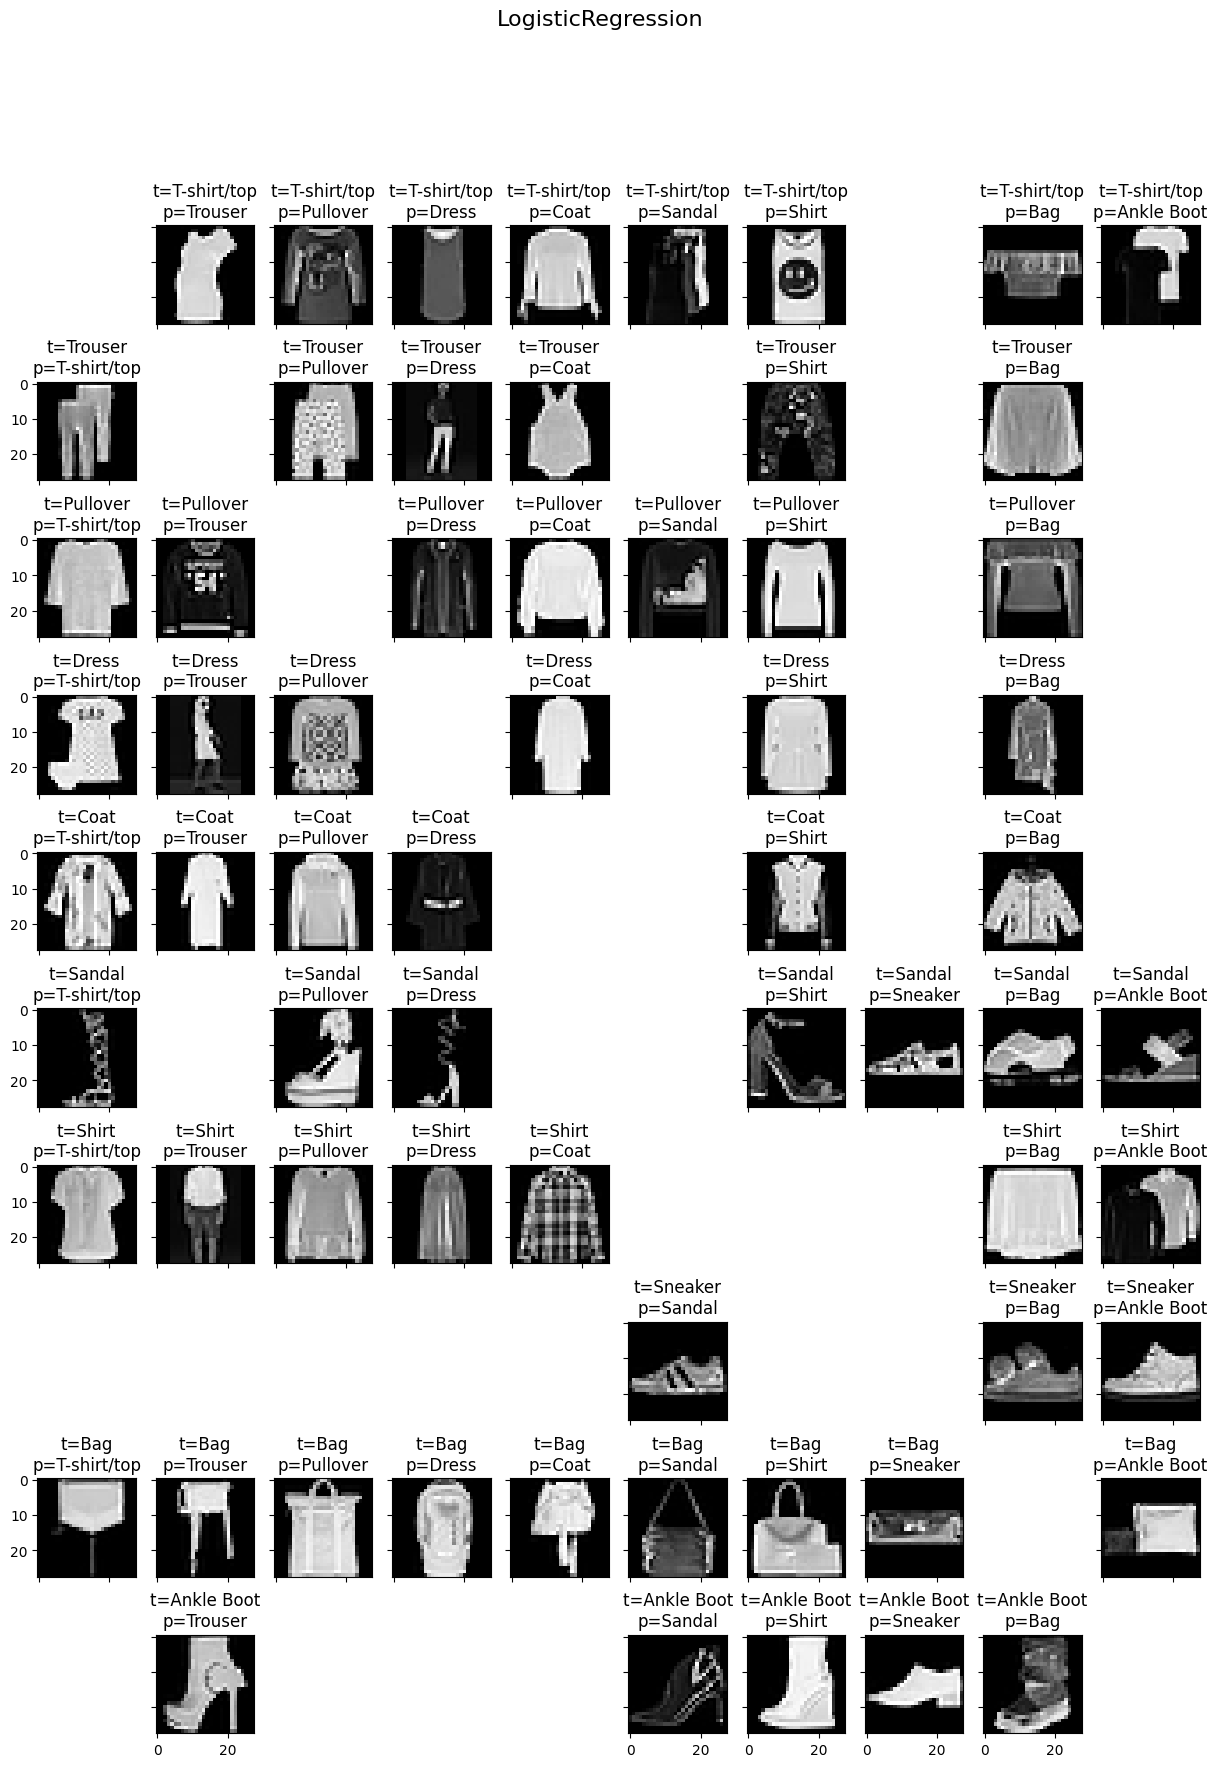

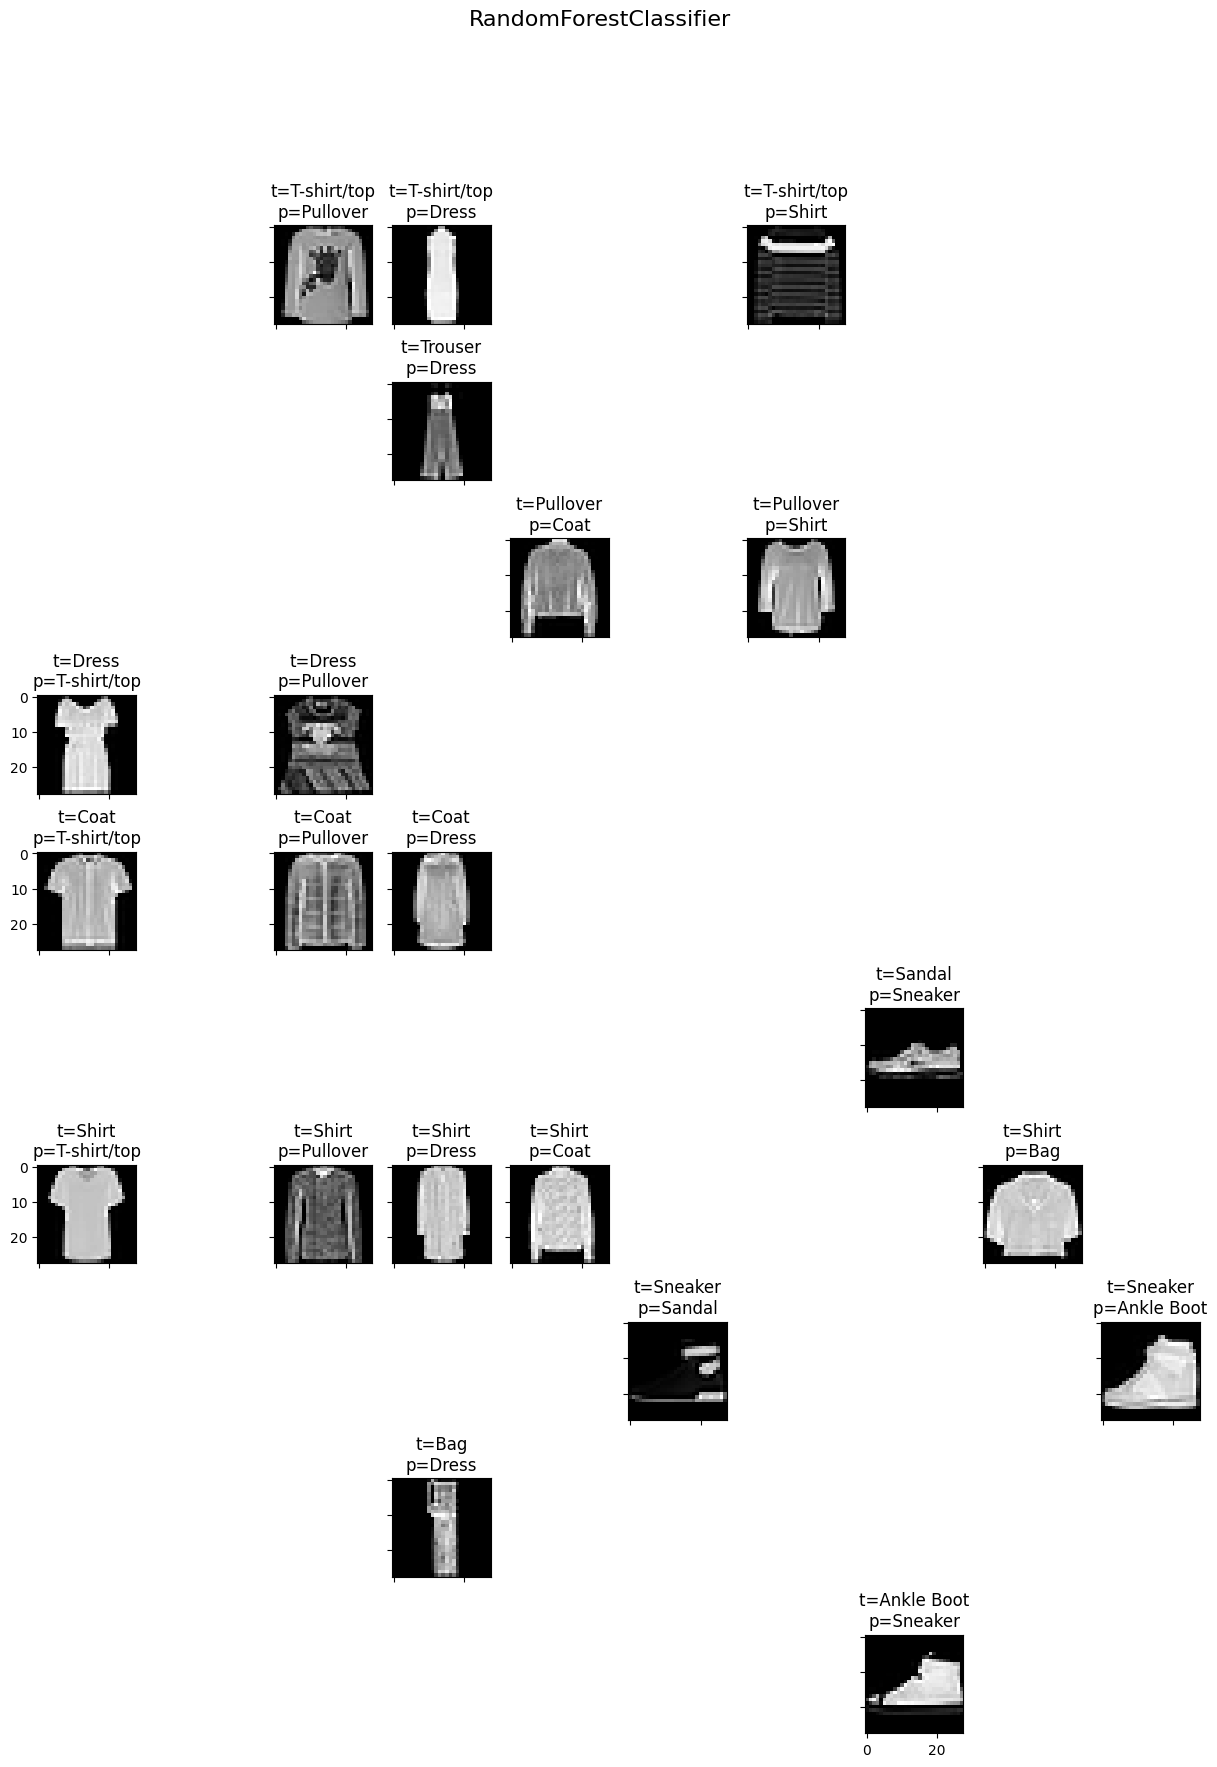

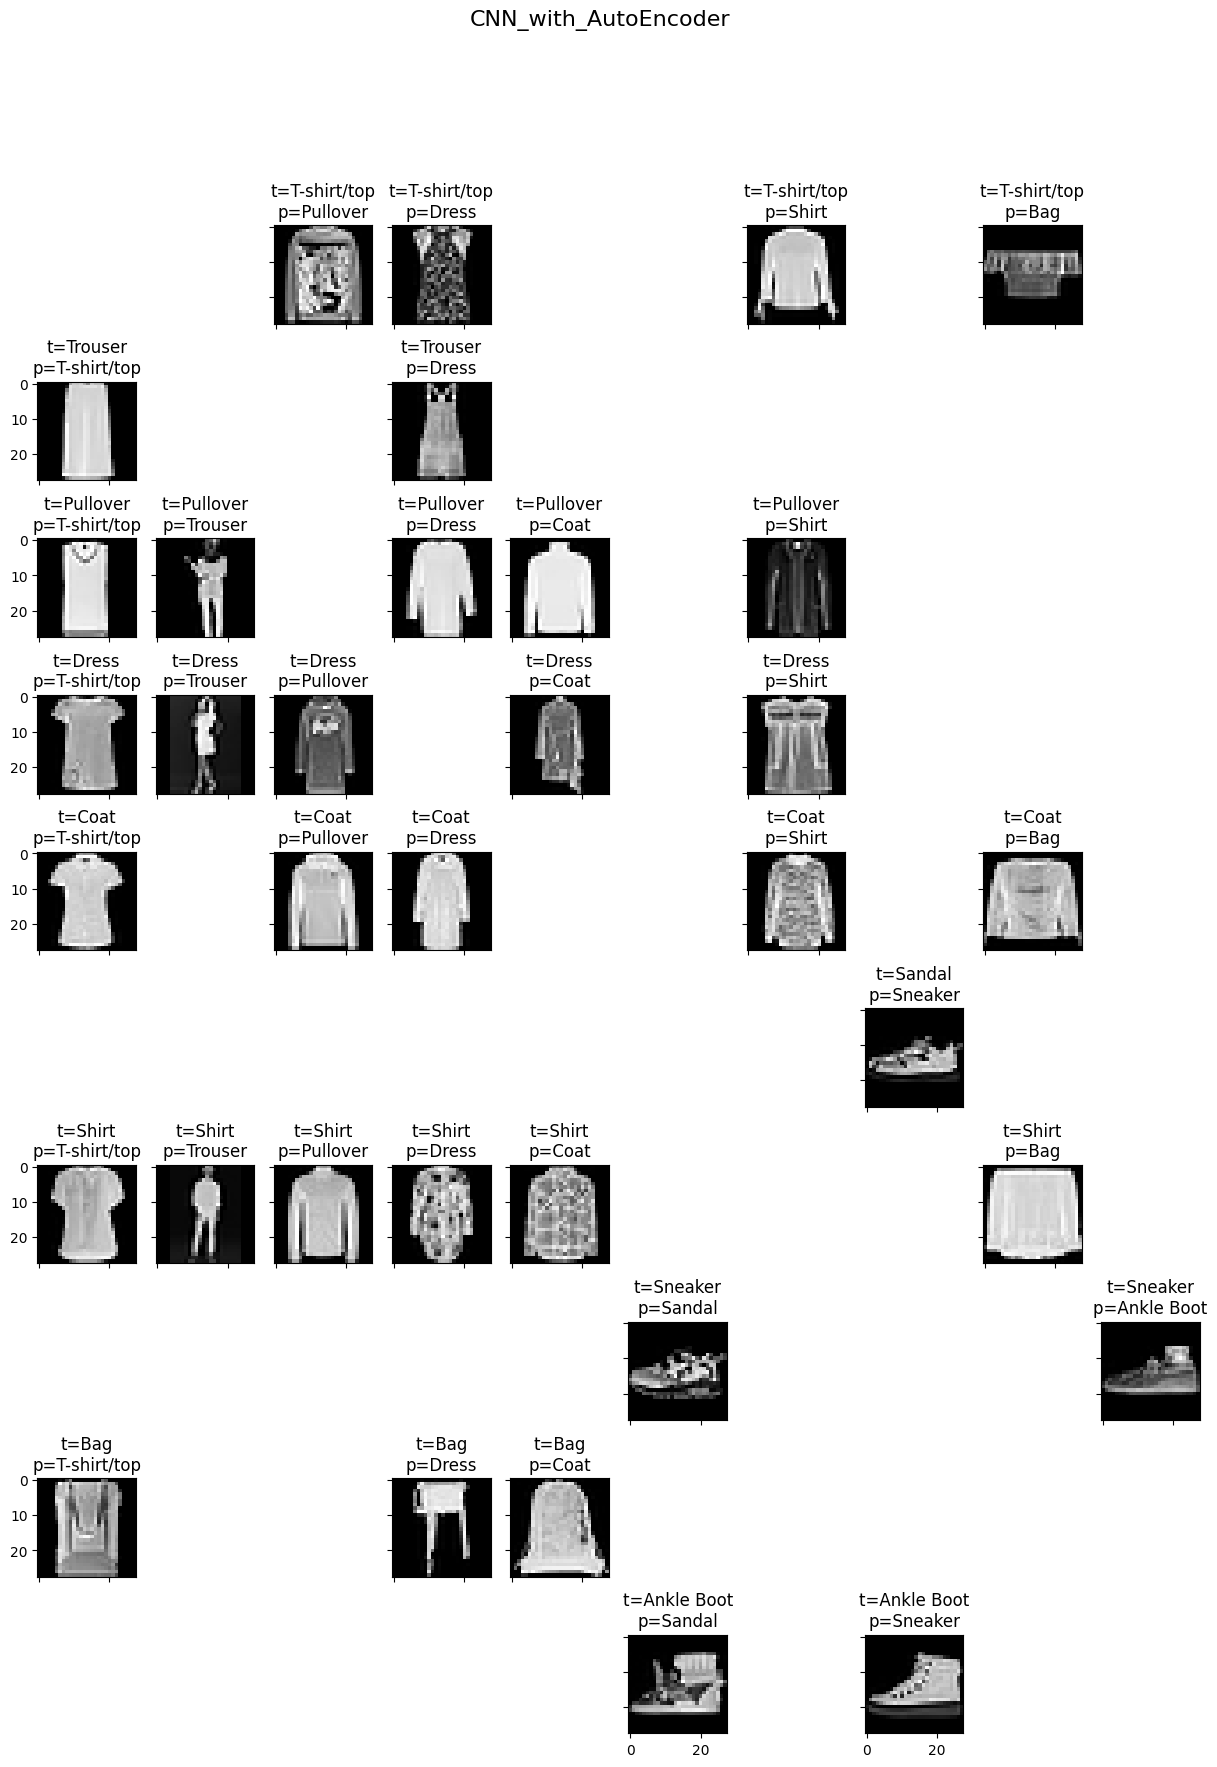

In [38]:
for name, model in models.items():
    pred = model.predict(X_tr)
    truth = y_tr

    idx = np.where(pred!=truth)
    Xs = X_tr[idx]
    pred = pred[idx]
    truth = truth[idx]

    fig, axes = plt.subplots(nrows=len(classes), ncols=len(classes), sharex=True, sharey=True, figsize=(1.5*len(classes), 2.*len(classes)))
    fig.suptitle(name, fontsize=16)

    for j, row in enumerate(axes):
        for i, ax in enumerate(row):
            X = Xs[(truth==j) & (pred==i)]
            if len(X) == 0:
                ax.axis('off')
            else:
                ax.set_title(f't={classes[j]}\np={classes[i]}')
                ax.imshow(X[0].reshape(28, 28), cmap='gray')
    plt.show()